In [1]:
import numpy as np
import pandas as pd
import random

from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from skimage.transform import resize
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import albumentations as A

from pathlib import Path
# import SimpleITK as sitk
# import pydicom
import os,sys
import matplotlib.pyplot as plt
# import cv2

/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup GPU

In [4]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=6)

## Load Data

In [5]:
meta = pd.read_csv('../zhout/Documents/mask_vol_all.csv')
meta['file_path'] = meta['PiCare PatientID'] + '_'+ meta['StudyDateAnon'].str.replace('-','') 

/tmp/ipykernel_34283/325357892.py:1: DtypeWarning: Columns (9,27,45,59,60,61,76,93,94,98,101,108,112,113,120) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../zhout/Documents/mask_vol_all.csv')


In [7]:
meta.shape

(8461, 125)

In [8]:
meta['Failure-binary'].value_counts()

0    7768
1     693
Name: Failure-binary, dtype: int64

This is an unbalanced data, so we randomly select same number of negative data to make it balance.

In [9]:
def data_ratio(df,target = 'Failure-binary', ratio = 0.5):
    "ratio = positive/all"
    positive = df[df[target]==1]
    negative = df[df[target]==1]
    neg_ratio = 1-ratio
    

In [10]:
positive = meta[meta['Failure-binary']==1]

In [11]:
negative = meta[meta['Failure-binary']==0]
negative_samples = negative.sample(n = positive.shape[0])

In [12]:
data = pd.concat([positive,negative_samples])
data = data.sample(frac=1).reset_index(drop=True)
data.shape

(1386, 125)

In [10]:
#data = data[:100]

### Dataset

In [13]:
image_path = data['image_path']
mask_path = data['mask_path']

In [14]:
idx = 0
image_array = np.load(image_path[idx])
mask_array = np.load(mask_path[idx])

In [15]:
transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=256, height=256),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                        value = 0.0, p = .5),
            ])

In [16]:
img_array = resize(image_array,(32,128,128))
msk_array = resize(mask_array,(32,128,128))
stack_image = np.stack([img_array,msk_array]).transpose()

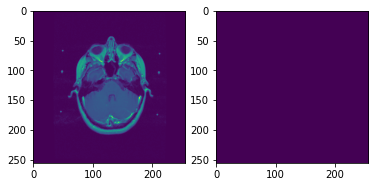

In [15]:
slice_idx = 18

plt.subplot(1,2,1)
plt.imshow(img_array[slice_idx])

plt.subplot(1,2,2)
plt.imshow(msk_array[slice_idx])

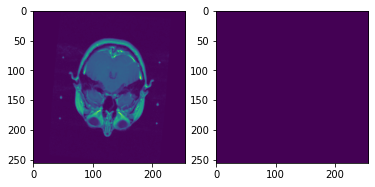

In [16]:
trasimg = transforms(image = img_array.transpose(),mask = msk_array.transpose())
# print(trans_img)
# tranim = a.transpose()
plt.subplot(1,2,1)
plt.imshow(trasimg['image'].transpose()[slice_idx])

plt.subplot(1,2,2)
plt.imshow(trasimg['mask'].transpose()[slice_idx])

In [17]:
def read_image_resize(path,image_size):
    images = []
    for image in tqdm(path):
        single_image = np.load(image)
        ### Resize and transform the image
        resized_single_image = np.swapaxes(resize(single_image,image_size),2,0)
        images.append(resized_single_image)
    return images 

In [18]:
class BrainMetDataset(Dataset):
    def __init__(self, image_path, mask_path, labels, transform = True, img_size = (32,128,128),load_ram = True):
        self.load_ram = load_ram
        if load_ram == True:
            self.image = read_image_resize(image_path,img_size)
            self.mask = read_image_resize(mask_path,img_size)
        else:
            self.image_path = image_path
            self.mask_path = mask_path
            
        self.labels = labels
        self.img_size = img_size
        if transform == True:
            self.transformation = A.Compose([
                # spatial transforms
                A.RandomCrop(width=128, height=128),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                        value = 0.0, p = .5)])
        else:
            self.transformation = A.Compose([])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        y = self.labels[index]
        
        if self.load_ram == True:
            img_array = self.image[index]
            msk_array = self.mask[index]

        else:
            img_array = np.load(self.image_path[index])
            msk_array = np.load(self.mask_path[index])

            img_array = resize(img_array,self.img_size).transpose()
            msk_array = resize(msk_array,self.img_size).transpose()

        
        trans = self.transformation(image = img_array,mask = msk_array)
        trans_img = trans['image'].transpose()
        trans_msk = trans['mask'].transpose()
        ### output should be torch tensor
        return torch.tensor([trans_img,trans_msk],dtype=torch.double), torch.tensor(y,dtype=torch.double)

In [19]:
def get_train_valid(subset):
    np.random.seed(5)
    msk = np.random.rand(len(subset))<0.8
    train = subset[msk].reset_index()
    valid = subset[~msk].reset_index()
    return train,valid

def get_paths(train,img_path = 'image_path',msk_path = 'mask_path', label = 'Failure-binary'):
    return np.array(train[img_path]),np.array(train[msk_path]),np.array(train[label])
    
train,valid = get_train_valid(data)
# train,valid = get_train_valid(subset)

t_img,t_msk,t_label = get_paths(train)
v_img,v_msk,v_label = get_paths(valid)

In [20]:
%%time
train_ds = BrainMetDataset(t_img,t_msk,t_label)
valid_ds = BrainMetDataset(v_img,v_msk,v_label)


100%|█████████████████████████████████████████| 274/274 [02:33<00:00,  1.78it/s]

CPU times: user 17min 45s, sys: 2min 38s, total: 20min 23s
Wall time: 24min 42s


In [21]:
train_dl = DataLoader(train_ds,batch_size=1,shuffle=True)
valid_dl = DataLoader(valid_ds,batch_size=1,shuffle=False)

In [22]:
a = next(iter(train_dl))

## CNN/UNET Model

In [23]:
# https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, f_size, padding=(pad,pad,pad))
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, f_size, padding=(pad,pad,pad))
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x
    
    
class half_unet(nn.Module):
    
    def __init__(self, h = 50):
        
        super().__init__()
        
        # pooling
        self.pool = nn.MaxPool3d(2,2)
        
        # ENCODER

        # block 00 (down)
        #self.conv00 = ConvBlock(1+len(masks), channels[0])
        self.conv00 = ConvBlock(input_channels, channels[0])
        # block 10 (down)
        self.conv10 = ConvBlock(channels[0], channels[1])
        # block 20 (down)
        self.conv20 = ConvBlock(channels[1],channels[2])
        # block 30 (down)
        self.conv30 = ConvBlock(channels[2],channels[3])
        
        # final layers
        self.final04 = nn.Conv3d(channels[3],1,1)
        self.linear1 = nn.Linear(in_features = 8192,out_features=h)
        self.linear2 = nn.Linear(in_features = h,out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x = self.conv30(self.pool(x20))
        

        
        # Outputs
        x = self.final04(x)
        x = x.view(x.size(0), -1)#.flatten()
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

In [24]:
def train_loop(model,train_dl,valid_dl, optimizer, epochs, loss_best = 1):
    for i in range(epochs): ## going through all your training data once
        model.train()
        losses = []
        for x, y in train_dl:
            y = y.unsqueeze(1)
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x.float())
            loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())## loss is a tensor of one number, if we call item(), we just keep the number
        
        model.eval()
        train_loss = np.mean(losses)
        valid_loss, valid_acc, valid_roc_auc,precision, recall= val_metric(model, valid_dl)
        print("train loss %.4f valid loss %.4f valid ROC_AUC %.4f valid ACC %.4f valid Precision %.4f valid Recall %.4f" % 
              (train_loss, valid_loss,valid_roc_auc,valid_acc,precision,recall))
        if valid_loss < loss_best:
#             now = datetime.now()
#             dt_string = now.strftime("%d/%m/%Y-%H:%M:%S")
            checkpoint = {'model_state_dict': model.state_dict(),
                          'optimizer_state_dict' :optimizer.state_dict()}
            torch.save(checkpoint, 'hu2.pt')
            loss_best = valid_loss
    return loss_best

In [25]:
def val_metric(model, valid_dl):
    model.eval()
    losses = []
    y_preds = []
    ys = []
    for x, y in valid_dl:  
        y = y.unsqueeze(1)
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x.float())
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        y = y.cpu()
        y_pred = torch.sigmoid(y_hat).cpu()
        y_preds.append(y_pred.detach().numpy())
        ys.extend(y.detach().numpy()) 
        losses.append(loss.item())
#    print(ys)
    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_preds)
    y_preds_ = np.array([1. if y >=0.5 else 0. for y in y_hats])
    correct = (ys == y_preds_).sum()
    val_acc = correct/len(ys)
    precision = precision_score(ys,y_preds_)
    recall = recall_score(ys,y_preds_)
#     print(ys,y_preds_,correct)    


    return np.mean(losses), val_acc,roc_auc_score(ys,y_hats),precision, recall

In [38]:
%%time

try:
    del model
    # del x,y
    del optimizer
    torch.cuda.empty_cache()
except:
    pass

def update_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

channels = [2, 4, 8, 16]
input_channels = 2
f_size = 3
pad = int((f_size-1)/2)


# model = CNN().to(device)
model = half_unet()
# model = nn.DataParallel(model, device_ids = [0,1,2,3]).to(device)
# model = half_unet().to(device)
model = nn.DataParallel(model, device_ids = [6]).to(device)
best = 1

CPU times: user 23.7 ms, sys: 15.5 ms, total: 39.1 ms
Wall time: 37.6 ms


In [39]:
learning_rate = 0.001
wd = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay= wd)

In [40]:
checkpoint = torch.load('hu1.pt')

In [41]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [42]:
def load_model(path):
    checkpoint = torch.load(path)
    
    if len(checkpoint)==2:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        model.load_state_dict(checkpoint)
load_model('hu1.pt')      

In [43]:
%%time
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)
#mm1.pt

1
train loss 0.6958 valid loss 0.6941 valid ROC_AUC 0.5000 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
train loss 0.6934 valid loss 0.6941 valid ROC_AUC 0.5000 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 0.6910 valid loss 1.8939 valid ROC_AUC 0.4239 valid ACC 0.5328 valid Precision 0.0000 valid Recall 0.0000
train loss 0.6972 valid loss 0.6944 valid ROC_AUC 0.4590 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
train loss 0.6938 valid loss 0.6946 valid ROC_AUC 0.5221 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
0.6940772263673101
CPU times: user 15h 52min 37s, sys: 3h, total: 18h 52min 38s
Wall time: 6h 37min 21s


In [44]:
%%time
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)
#mm1.pt

0.6940772263673101
train loss 0.6935 valid loss 0.6944 valid ROC_AUC 0.4497 valid ACC 0.4708 valid Precision 0.4689 valid Recall 1.0000
train loss 0.6933 valid loss 0.6944 valid ROC_AUC 0.4959 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
train loss 0.6932 valid loss 0.6942 valid ROC_AUC 0.4583 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
train loss 0.6933 valid loss 0.6940 valid ROC_AUC 0.5260 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
train loss 0.6934 valid loss 0.6942 valid ROC_AUC 0.5205 valid ACC 0.4672 valid Precision 0.4672 valid Recall 1.0000
0.694039348485696
CPU times: user 16h 5min 35s, sys: 2h 59min 37s, total: 19h 5min 13s
Wall time: 6h 8min 47s


In [ ]:
# model = unet2().to(device)
# m1 = torch.load('m.pt')
# model.load_state_dict(m1)

In [ ]:
# model = unet().to(device)
# m2 = torch.load('m2.pt')
# model.load_state_dict(m2)

In [ ]:
%%time
#m2.pt
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)

0.694039348485696
train loss 0.6936 valid loss 0.6936 valid ROC_AUC 0.5568 valid ACC 0.5073 valid Precision 0.4861 valid Recall 0.9531


In [ ]:
%%time
#m3.pt
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)